In [1]:
!nvidia-smi

Wed Feb 21 04:31:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm
from keras.utils import normalize
from matplotlib import pyplot as plt
from skimage.transform import resize
from keras.utils import to_categorical
from matplotlib.patches import Rectangle
from sklearn.metrics import average_precision_score

seed = 42
SIZE_X = 448
SIZE_Y = 448
n_channels = 3
n_classes = 10
Batch_size = 8
EPOCHS = 100
MODEL = 'unet'
BACKBONE = 'Vanilla Mini CNN'

parent_directory = r'/content/FloodNet-Supervised_v1.0'

In [ ]:
!unzip '/content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/FloodNet-Supervised_v1.0.zip'

In [2]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}

color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128],
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]
    return label_seg

def display_images_with_masks(image, mask, predicted):
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(np.expand_dims(mask, axis=-1), (1, 1, 3))))
    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict()
mask_data_gen_args = dict()

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(f"{parent_directory}/train_images",
                                                           seed=seed,
                                                           batch_size=Batch_size,
                                                           class_mode=None,
                                                           target_size=(SIZE_X, SIZE_Y))

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(f"{parent_directory}/train_masks",
                                                         seed=seed,
                                                         batch_size=Batch_size,
                                                         color_mode = 'grayscale',
                                                         class_mode=None,
                                                         target_size=(SIZE_X, SIZE_Y))


valid_img_generator = image_data_generator.flow_from_directory(f"{parent_directory}/val_images",
                                                           seed=seed,
                                                           batch_size=Batch_size,
                                                           class_mode=None,
                                                           target_size=(SIZE_X, SIZE_Y))

valid_mask_generator = mask_data_generator.flow_from_directory(f"{parent_directory}/val_masks",
                                                         seed=seed,
                                                         batch_size=Batch_size,
                                                         color_mode = 'grayscale',
                                                         class_mode=None,
                                                         target_size=(SIZE_X, SIZE_Y))

train_generator = zip(image_generator, mask_generator)
valid_generator = zip(valid_img_generator, valid_mask_generator)

Found 1445 images belonging to 1 classes.
Found 1445 images belonging to 1 classes.
Found 450 images belonging to 1 classes.
Found 450 images belonging to 1 classes.


In [ ]:
batch = next(train_generator)
images, masks = batch

In [ ]:
images.shape, masks.shape

((8, 448, 448, 3), (8, 448, 448, 1))

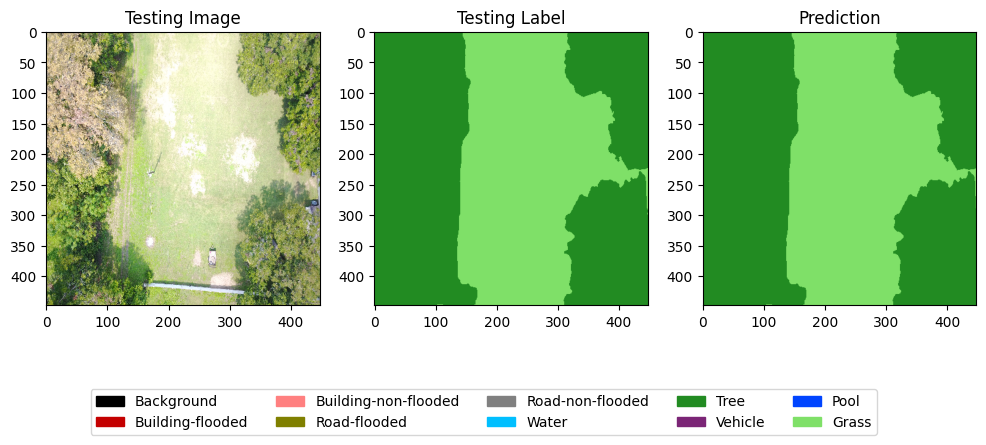

In [ ]:
import numpy as np
import random

num = random.randint(0, len(images)-1)
display_images_with_masks((images[num]).astype(np.uint8), np.squeeze(masks[num], axis=-1), np.squeeze(masks[num], axis=-1))

In [3]:
def preprocess_data(images, masks, unet_preporcessing=None):
    if unet_preporcessing:
        images = unet_preporcessing(images)
    else:
        images = normalize(images, axis=1)

    masks = to_categorical(masks, num_classes=n_classes)
    masks = masks.reshape((masks.shape[0], -1, n_classes))

    return images, masks

def reverse_masks_shape(masks):
    masks = masks.reshape((masks.shape[0], SIZE_X, SIZE_Y, n_classes))
    return masks

In [ ]:
from tensorflow.keras.utils import to_categorical

def load_data(image_generator, mask_generator, preprocessing_function=None):
    for (img, mask) in zip(image_generator, mask_generator):
        img, mask = preprocess_data(img, mask)
        yield (img, mask)

In [ ]:
train_generator = load_data(image_generator, mask_generator)
val_generator = load_data(valid_img_generator, valid_mask_generator)

In [ ]:
batch = next(train_generator)
images, masks = batch

In [ ]:
images[0].shape, masks[0].shape

((448, 448, 3), (200704, 10))

In [ ]:
images.shape, masks.shape

((8, 448, 448, 3), (8, 200704, 10))

In [8]:
!pip install keras_segmentation
!pip install segmentation_models

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.3/753.3 kB 34.3 MB/s eta 0:00:00
  Created wheel for keras_segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=29057 sha256=366ed740ad75ec08e9fb699dd2cef189c283c0b0a51561ac6921b4dc29c61c0c
  Stored in directory: /root/.cache/pip/wheels/2a/87/5b/ddc104c262fe1280e0565a2cc1b9b6b04963af12e462cdf068
Successfully built keras_segmentation
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.4.0
    Uninstalling imgaug-0.4.0:
      Successfully uninstalled imgaug-0.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00


In [4]:
from keras_segmentation.models.all_models import unet, pspnet, fcn, segnet
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

model = None

if MODEL == 'unet':
    if BACKBONE == 'Vanilla Mini CNN':
        model = unet.unet_mini(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'Vanilla CNN':
        model = unet.unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'ResNet-50':
        model = unet.resnet50_unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'VGG-16':
        model = unet.vgg_unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'MobileNet':
        model = unet.mobilenet_unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
elif MODEL == 'pspnet':
    if BACKBONE == 'Vanilla CNN':
        model = pspnet.pspnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'Vanilla CNN (50)':
        model = pspnet.pspnet_50(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'Vanilla CNN (101)':
        model = pspnet.pspnet_101(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'ResNet-50':
        model = pspnet.resnet50_pspnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'VGG-16':
        model = pspnet.vgg_pspnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
elif MODEL == 'segnet':
    if BACKBONE == 'Vanilla CNN':
        model = segnet.segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'ResNet-50':
        model = segnet.resnet50_segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'VGG-16':
        model = segnet.vgg_segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'MobileNet':
        model = segnet.mobilenet_segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
else:
    raise ValueError('Unknown model')

if model:
    model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
    model.summary()
else:
    print('Model not found')

Segmentation Models: using `tf.keras` framework.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 448, 448, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 448, 448, 32)         896       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 448, 448, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 448, 448, 32)         9248      ['dropout[0][0]']             
                                           

In [10]:
model.input_shape, model.output_shape

((None, 448, 448, 3), (None, 200704, 10))

In [ ]:
train_samples = len(os.listdir(f"{parent_directory}/train_images/train"))
val_samples = len(os.listdir(f"{parent_directory}/val_images/val"))
train_samples, val_samples

(1445, 450)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=(train_samples//Batch_size), epochs=EPOCHS, validation_data=val_generator, validation_steps=(val_samples//Batch_size))

Epoch 1/100
180/180 [==============================] - 291s 2s/step - loss: 0.9217 - iou_score: 0.3568 - val_loss: 0.8824 - val_iou_score: 0.3699
Epoch 2/100
180/180 [==============================] - 290s 2s/step - loss: 0.8655 - iou_score: 0.3742 - val_loss: 0.8880 - val_iou_score: 0.3399
Epoch 3/100
180/180 [==============================] - 288s 2s/step - loss: 0.8480 - iou_score: 0.3847 - val_loss: 0.8235 - val_iou_score: 0.3900
Epoch 4/100
180/180 [==============================] - 286s 2s/step - loss: 0.8126 - iou_score: 0.4079 - val_loss: 0.8295 - val_iou_score: 0.3882
Epoch 5/100
180/180 [==============================] - 276s 2s/step - loss: 0.7975 - iou_score: 0.4157 - val_loss: 0.7907 - val_iou_score: 0.4225
Epoch 6/100
180/180 [==============================] - 275s 2s/step - loss: 0.7788 - iou_score: 0.4245 - val_loss: 0.7592 - val_iou_score: 0.4323
Epoch 7/100
180/180 [==============================] - 284s 2s/step - loss: 0.7651 - iou_score: 0.4328 - val_loss: 0.7923 - 

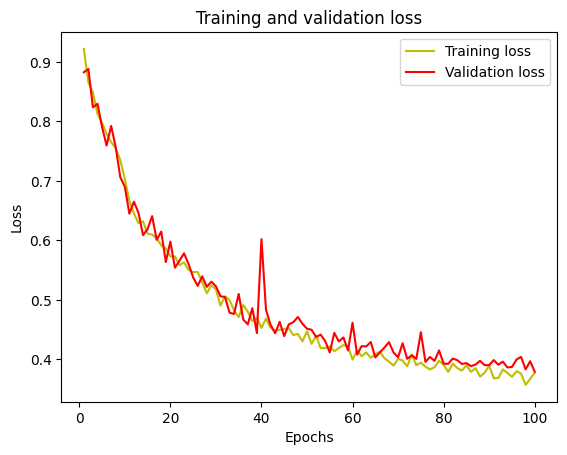

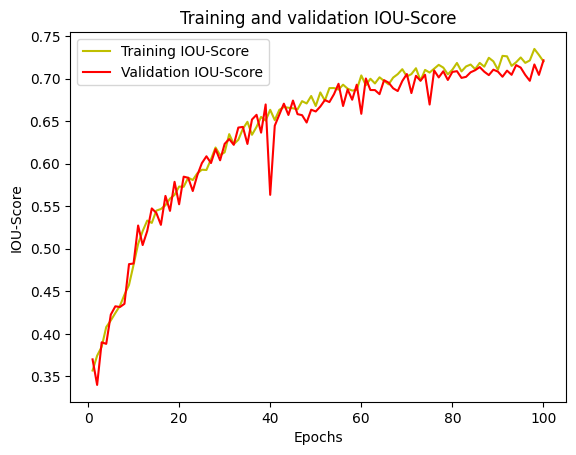

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IOU-Score')
plt.plot(epochs, val_acc, 'r', label='Validation IOU-Score')
plt.title('Training and validation IOU-Score')
plt.xlabel('Epochs')
plt.ylabel('IOU-Score')
plt.legend()
plt.show()

In [ ]:
model.save(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()})-({SIZE_X}x{SIZE_Y}).hdf5')

In [5]:
model.load_weights(f'/content/drive/MyDrive/Experiments/weights/UNET_model_with_100_epochs(UNET_Vanilla mini cnn)-(448x448).hdf5')
# model.load_weights(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()})-({SIZE_X}x{SIZE_Y}).hdf5')

In [6]:
def load_images(parent_directory, split='train'):
    images = []
    masks = []

    image_folder_path = f'{parent_directory}/{split}/{split}-org-img'
    for img_path in tqdm(glob.glob(os.path.join(image_folder_path, "*.jpg"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        images.append(img)

        mask_path = (img_path.replace('org', 'label')).replace('jpg', 'png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    print(f'{split.upper()}: Images loaded: {images.shape[0]}')
    print(f'{split.upper()}: Masks loaded: {masks.shape[0]}')

    return images, masks

In [7]:
test_parent_directory = r'/content/FloodNet-Supervised_v1.0'

test_images, test_masks = load_images(test_parent_directory, split='test')
test_images_seperate = test_images

test_images, test_masks = preprocess_data(test_images, test_masks)

100%|██████████| 448/448 [01:52<00:00,  3.98it/s]


TEST: Images loaded: 448
TEST: Masks loaded: 448


In [ ]:
data_to_save = {
    'test_images': test_images,
    'test_masks': test_masks,
    'test_images_seperate': test_images_seperate
}

pickle_file_path = f'../../dataset/test_data({SIZE_X}x{SIZE_Y}).pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

In [ ]:
pickle_file_path = f'../../dataset/test_data({SIZE_X}x{SIZE_Y}).pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

test_images = loaded_data['test_images']
test_masks = loaded_data['test_masks']
test_images_seperate = loaded_data['test_images_seperate']

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Shapes of loaded data:
Test Images: (448, 224, 224, 3)
Test Masks: (448, 224, 224, 10)


In [15]:
_, acc = model.evaluate(test_images, test_masks, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  48.932307958602905 %


In [8]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)

print(y_pred.shape)
print(test_masks.shape)

predicted_masks = reverse_masks_shape(y_pred)
test_masks = reverse_masks_shape(test_masks)

print(predicted_masks.shape)
print(test_masks.shape)

predicted_masks = np.argmax(predicted_masks, axis=-1)
test_masks_ = np.argmax(test_masks, axis=-1)

14/14 [==============================] - 8s 116ms/step
(448, 200704, 10)
(448, 200704, 10)
(448, 448, 448, 10)
(448, 448, 448, 10)


In [9]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    if i == 0:
        continue
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

mean_IoU_without_background = np.mean(class_IoUs)
print("Mean IoU (excluding Background):", mean_IoU_without_background)

Mean IoU = 0.24138856
IoU for each class:
Building Flooded: 0.23635540902614594
Building Non-Flooded: 0.1997734010219574
Road Flooded: 0.22727607190608978
Road Non-Flooded: 0.4709557592868805
Water: 0.4487113952636719
Tree: 0.30302268266677856
Vehicle: 0.08824257552623749
Pool: 0.0016126445261761546
Grass: 0.42434486746788025
Mean IoU (excluding Background): 0.2666994


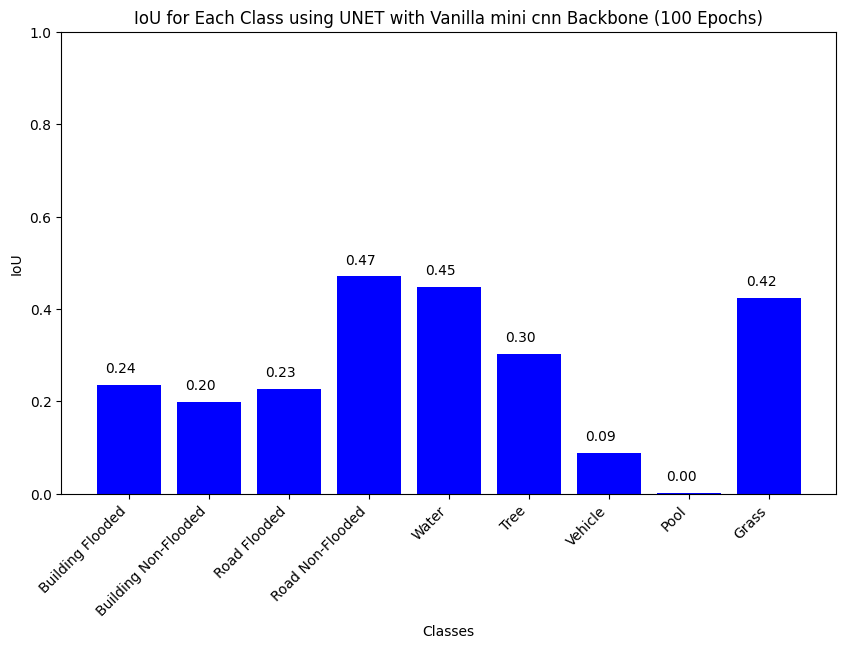

In [10]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names[1:], class_IoUs, color='blue')
plt.title(f'IoU for Each Class using {MODEL.upper()} with {BACKBONE.capitalize()} Backbone ({EPOCHS} Epochs)')
plt.xlabel('Classes')
plt.ylabel('IoU')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')

for bar, value in zip(bars, class_IoUs):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [11]:
def display_random_function():
    image_id = np.random.randint(0, len(test_images))
    image = test_images_seperate[image_id]
    ground_truth_mask = test_masks_[image_id]
    predicted_mask = predicted_masks[image_id]

    print(f'Image Shape: {image.shape}')
    print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
    print(f'Predicted Mask Shape: {predicted_mask.shape}')

    display_images_with_masks(image, ground_truth_mask, predicted_mask)

Image Shape: (448, 448, 3)
Ground Truth Mask Shape: (448, 448)
Predicted Mask Shape: (448, 448)


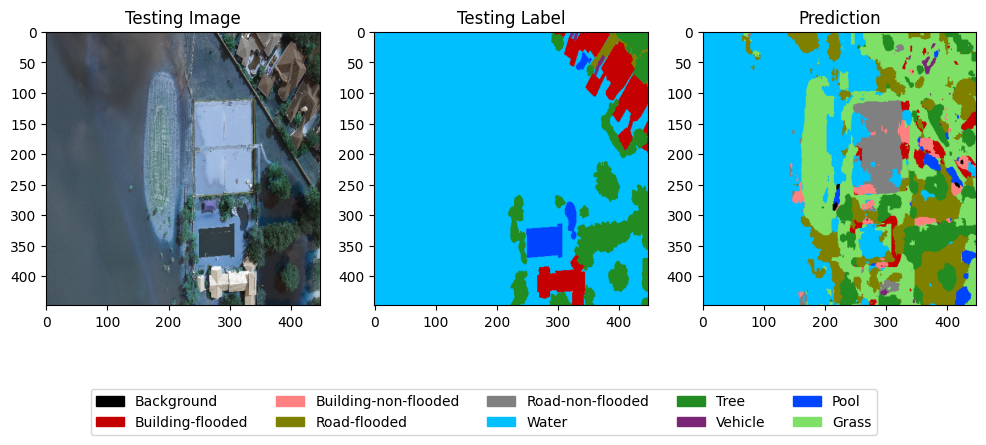

In [12]:
display_random_function()

Image Shape: (448, 448, 3)
Ground Truth Mask Shape: (448, 448)
Predicted Mask Shape: (448, 448)


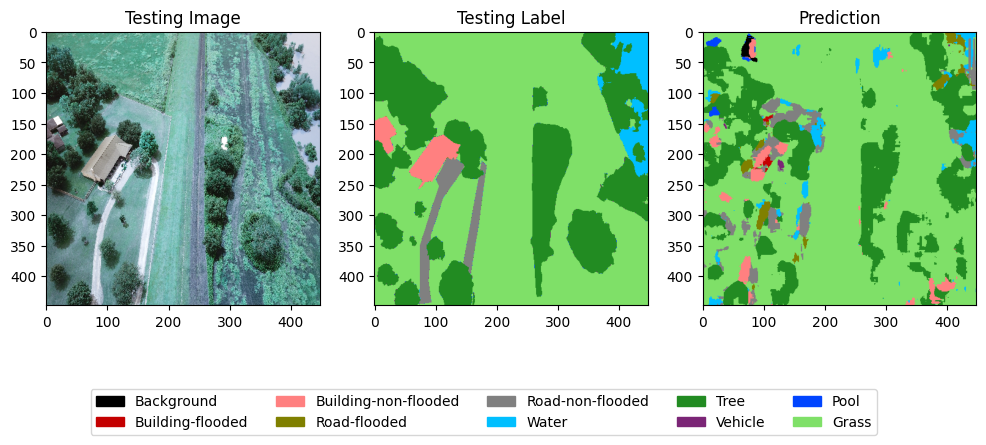

In [13]:
display_random_function()

Image Shape: (448, 448, 3)
Ground Truth Mask Shape: (448, 448)
Predicted Mask Shape: (448, 448)


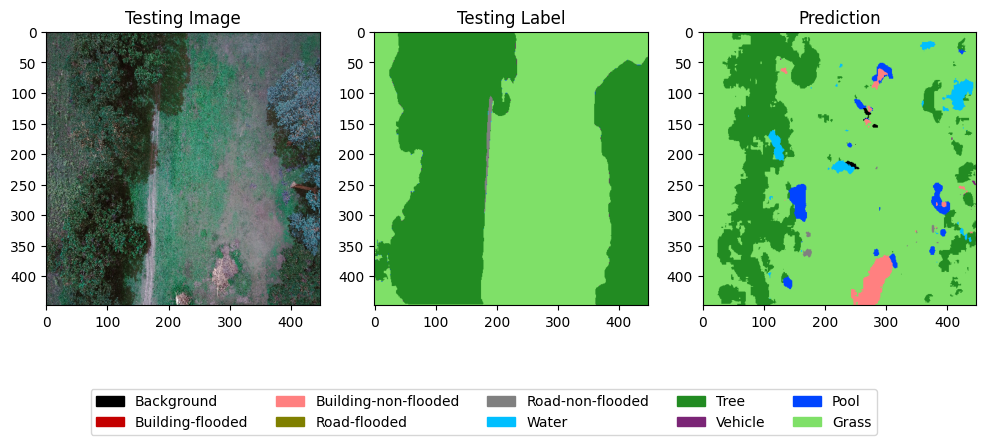

In [14]:
display_random_function()

Image Shape: (448, 448, 3)
Ground Truth Mask Shape: (448, 448)
Predicted Mask Shape: (448, 448)


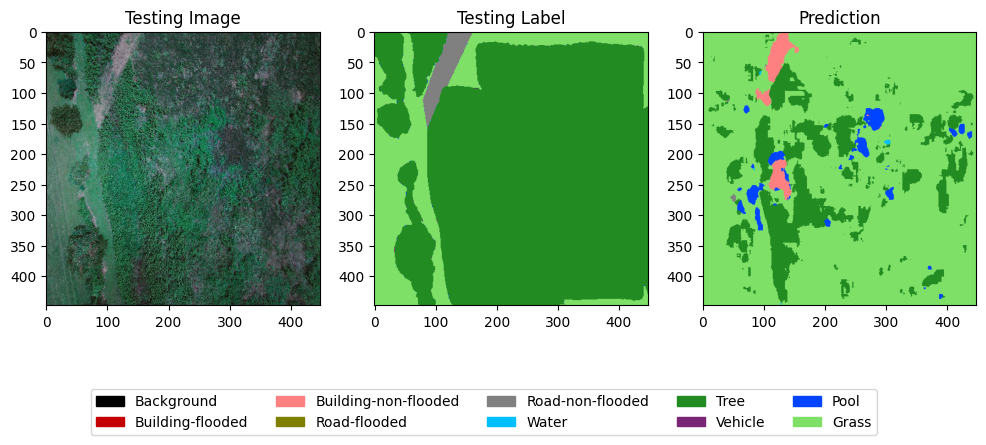

In [15]:
display_random_function()

Image Shape: (448, 448, 3)
Ground Truth Mask Shape: (448, 448)
Predicted Mask Shape: (448, 448)


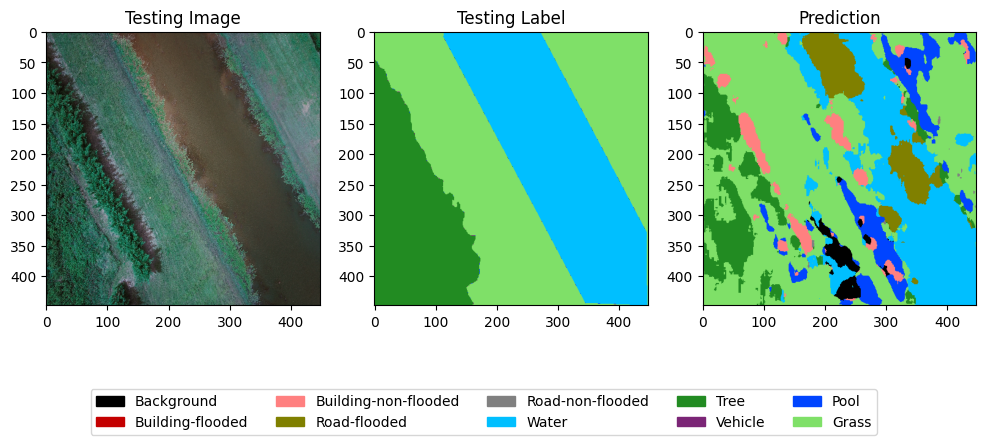

In [16]:
display_random_function()